<a href="https://colab.research.google.com/github/ARBasharat/AudioClassification/blob/master/AudioClassification1D_noAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contact: abbash@iu.edu <br/>
1D Classification without Augmentation


# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import librosa
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

# Load Data from Google Colab

In [2]:
from google.colab import drive
drive.mount("/content/drive")

train = np.load("drive/My Drive/AudioClassification/audio_train.npy").astype('float32')
test = np.load("drive/My Drive/AudioClassification/audio_test.npy").astype('float32')
train_labels_df = pd.read_csv("drive/My Drive/AudioClassification/labels_train.csv")

Mounted at /content/drive


# Data Preperation

In [3]:
train_labels = train_labels_df.to_numpy()[:,1]
labels_categorical = keras.utils.to_categorical(train_labels)

X_train_original, X_val_original, y_train_original, y_val = train_test_split(train, 
                          labels_categorical, test_size=0.20, random_state=42)

print("Training Data:", X_train_original.shape)
print("Training Labels:", y_train_original.shape)
print("Validation Data:", X_val_original.shape)
print("Validation Labels:", y_val.shape)
print("Testing Data:", test.shape)

Training Data: (753, 30000)
Training Labels: (753, 10)
Validation Data: (189, 30000)
Validation Labels: (189, 10)
Testing Data: (558, 30000)


In [4]:
# Get training data without augmentation
def get_data_2(X_train_original, y_train_original):
  new_data = []
  new_labels = []
  for i in range(0, len(X_train_original)):
    data = X_train_original[i]
    label = y_train_original[i]
    new_data.append(data)
    new_labels.append(label)
  train_data = np.array(new_data)
  y_train = np.array(new_labels)
  return train_data, y_train

train_data, y_train = get_data_2(X_train_original, y_train_original)
print(train_data.shape, y_train.shape)

(753, 30000) (753, 10)


In [5]:
## Normalize data
train_data /= train_data.max()
X_val_original /= X_val_original.max()
test /= test.max()

In [6]:
X_train = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
X_val = X_val_original.reshape((X_val_original.shape[0], X_val_original.shape[1], 1))
X_test = test.reshape((test.shape[0], test.shape[1], 1))
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape)

(753, 30000, 1) (189, 30000, 1) (558, 30000, 1) (753, 10) (189, 10)


# Define Model

In [22]:
## Base Model Architecture 
def getBaseModel():
  model = models.Sequential()
  model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(30000, 1)))
  model.add(layers.MaxPooling1D(2))
  model.add(layers.Conv1D(64, 3, activation='relu'))
  model.add(layers.MaxPooling1D(2))
  model.add(layers.Conv1D(128, 3, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.summary()
  return model

def get_model_2():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv1D(32, kernel_size=3, activation='relu', 
                    input_shape=(30000, 1)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv1D(48, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(120, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation='softmax'))
  return model

def get_model_3():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv1D(32, kernel_size=3, activation='relu', 
                    input_shape=(30000, 1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation='softmax'))
  return model

In [12]:
## Compile and Train Model with Early stopping
def compileTrainModel(model, optimizer = 'adam', epochs = 10):
  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  
  model.compile(optimizer=optimizer,
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=epochs, verbose=2, batch_size=64,
          validation_data=(X_val, y_val), callbacks=earlyStopping)
  
  return history

## Plot Training History
def plotTrainingAccuracy(history):
  plt.figure()
  plt.plot(history.history['accuracy'], label='training_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')
  plt.show()
  plt.close()

def plotTrainingLoss(history):
  plt.figure()
  plt.plot(history.history['loss'], label='training_loss')
  plt.plot(history.history['val_loss'], label = 'validation_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper left')
  plt.show()
  plt.close()

## Evaluate the model
def predictModel(model, test):
  return model.predict_classes(test, verbose=0)
  

## Evaluate the model
def evaluateModel(model, X_test, y_test):
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
  print("\n ### Performance of Test Data ###")
  print("Validation Accuracy: ", test_acc)
  print("Validation Loss: ", test_loss, "\n")

# Train Model 1

In [10]:
model = getBaseModel()
history = compileTrainModel(model, optimizer = 'adam', epochs = 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29998, 32)         128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14999, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14997, 64)         6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7498, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7496, 128)         24704     
_________________________________________________________________
flatten (Flatten)            (None, 959488)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

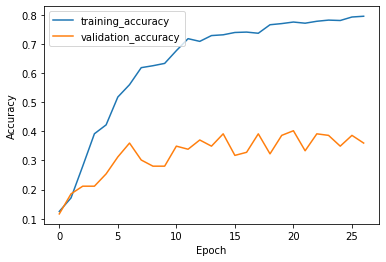

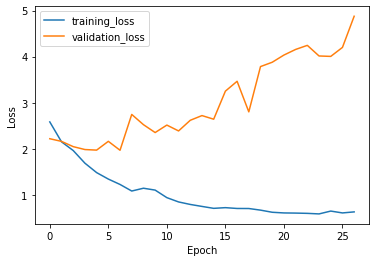


 ### Performance of Test Data ###
Validation Accuracy:  0.35978835821151733
Validation Loss:  4.876947402954102 



In [13]:
plotTrainingAccuracy(history)
plotTrainingLoss(history)
evaluateModel(model, X_val, y_val)

In [15]:
predictions = predictModel(model, X_test)
predictions

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([5, 5, 4, 1, 1, 5, 9, 9, 0, 0, 1, 0, 4, 8, 0, 1, 4, 4, 5, 1, 4, 6,
       0, 4, 1, 5, 5, 1, 0, 1, 5, 4, 8, 0, 6, 0, 6, 0, 4, 0, 0, 1, 1, 9,
       8, 0, 1, 1, 1, 1, 0, 6, 1, 0, 8, 1, 5, 0, 0, 0, 0, 1, 8, 4, 0, 0,
       1, 6, 1, 1, 0, 4, 0, 4, 1, 1, 1, 6, 1, 1, 0, 1, 6, 0, 1, 0, 0, 0,
       9, 6, 0, 8, 0, 4, 1, 1, 1, 0, 6, 6, 6, 3, 1, 1, 1, 0, 1, 4, 0, 0,
       1, 0, 1, 5, 0, 0, 1, 5, 5, 1, 5, 0, 0, 1, 0, 1, 3, 1, 1, 3, 8, 1,
       6, 8, 3, 0, 4, 1, 4, 4, 1, 8, 1, 8, 1, 0, 0, 0, 1, 1, 0, 0, 5, 0,
       3, 5, 3, 0, 1, 1, 3, 8, 0, 0, 8, 1, 6, 6, 4, 0, 5, 0, 1, 1, 6, 8,
       3, 0, 1, 1, 5, 4, 0, 0, 4, 4, 0, 1, 1, 1, 4, 6, 0, 4, 4, 8, 1, 5,
       0, 6, 5, 0, 1, 4, 6, 5, 0, 0, 1, 3, 0, 0, 4, 1, 1, 0, 6, 4, 3, 0,
       9, 0, 1, 0, 0, 1, 8, 8, 1, 0, 1, 0, 6, 5, 0, 8, 6, 8, 1, 0, 6, 5,
       6, 0, 8, 5, 0, 6, 1, 1, 0, 0, 6, 8, 0, 5, 4, 1, 0, 0, 0, 0, 5, 1,
       1, 3, 8, 1, 4, 4, 8, 1, 1, 1, 1, 6, 0, 0, 0, 1, 1, 1, 4, 3, 8, 0,
       6, 8, 1, 3, 0, 0, 0, 6, 0, 6, 4, 3, 1, 6, 8,

In [17]:
pd.DataFrame(predictions).to_csv("submission.csv")

# Train Model 2

In [18]:
model_2 = get_model_2()
history_2 = compileTrainModel(model_2, optimizer = 'adam', epochs = 100)

Epoch 1/100
12/12 - 5s - loss: 2.7288 - accuracy: 0.0943 - val_loss: 2.2850 - val_accuracy: 0.1429
Epoch 2/100
12/12 - 4s - loss: 2.2591 - accuracy: 0.1328 - val_loss: 2.2457 - val_accuracy: 0.1534
Epoch 3/100
12/12 - 4s - loss: 2.2150 - accuracy: 0.1514 - val_loss: 2.1780 - val_accuracy: 0.1164
Epoch 4/100
12/12 - 4s - loss: 2.1663 - accuracy: 0.1673 - val_loss: 2.1967 - val_accuracy: 0.1746
Epoch 5/100
12/12 - 4s - loss: 2.1321 - accuracy: 0.1806 - val_loss: 2.1351 - val_accuracy: 0.1852
Epoch 6/100
12/12 - 4s - loss: 2.0453 - accuracy: 0.2244 - val_loss: 2.0998 - val_accuracy: 0.2011
Epoch 7/100
12/12 - 4s - loss: 1.9923 - accuracy: 0.2284 - val_loss: 2.1346 - val_accuracy: 0.1852
Epoch 8/100
12/12 - 4s - loss: 1.9480 - accuracy: 0.2550 - val_loss: 2.0936 - val_accuracy: 0.2116
Epoch 9/100
12/12 - 4s - loss: 1.9188 - accuracy: 0.2789 - val_loss: 2.0649 - val_accuracy: 0.2222
Epoch 10/100
12/12 - 4s - loss: 1.8256 - accuracy: 0.3054 - val_loss: 2.0107 - val_accuracy: 0.2063
Epoch 11/

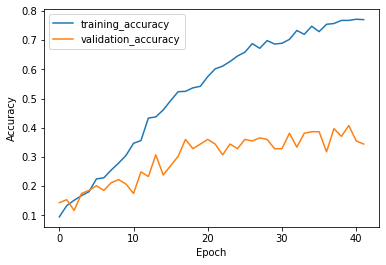

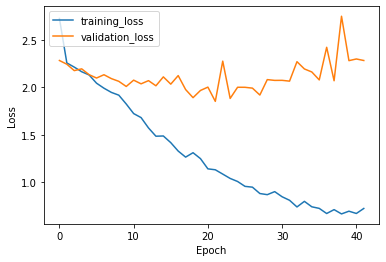


 ### Performance of Test Data ###
Validation Accuracy:  0.34391534328460693
Validation Loss:  2.2849442958831787 



In [19]:
plotTrainingAccuracy(history_2)
plotTrainingLoss(history_2)
evaluateModel(model_2, X_val, y_val)

In [20]:
predictions = predictModel(model_2, X_test)
predictions

array([8, 8, 4, 1, 3, 5, 0, 3, 6, 0, 1, 9, 8, 8, 3, 3, 3, 7, 8, 1, 7, 8,
       8, 3, 3, 8, 3, 0, 0, 1, 3, 1, 8, 3, 6, 1, 6, 6, 0, 9, 6, 1, 1, 0,
       3, 0, 6, 1, 3, 3, 3, 6, 1, 0, 8, 3, 8, 9, 1, 5, 3, 6, 8, 7, 0, 0,
       3, 6, 1, 3, 7, 8, 0, 3, 0, 1, 3, 7, 1, 3, 6, 1, 6, 8, 3, 6, 3, 6,
       3, 7, 0, 8, 0, 8, 3, 1, 6, 8, 3, 6, 6, 3, 3, 1, 3, 3, 1, 4, 3, 6,
       1, 1, 1, 5, 0, 0, 5, 5, 1, 1, 7, 0, 1, 1, 6, 1, 3, 6, 1, 3, 8, 3,
       1, 3, 3, 3, 3, 3, 3, 8, 7, 8, 0, 8, 7, 0, 0, 0, 7, 5, 3, 0, 8, 3,
       3, 0, 3, 6, 1, 1, 6, 8, 7, 6, 8, 1, 6, 6, 8, 0, 8, 0, 8, 6, 6, 1,
       3, 0, 6, 8, 0, 6, 8, 6, 8, 4, 6, 7, 1, 6, 8, 6, 3, 4, 8, 8, 4, 8,
       7, 7, 5, 7, 7, 8, 6, 6, 9, 0, 6, 3, 0, 3, 0, 9, 3, 3, 6, 3, 3, 6,
       9, 0, 1, 3, 6, 1, 8, 8, 6, 1, 3, 6, 8, 5, 1, 8, 6, 8, 3, 0, 6, 0,
       6, 6, 8, 1, 6, 6, 1, 1, 4, 1, 3, 8, 0, 8, 8, 6, 7, 6, 3, 6, 3, 6,
       3, 3, 8, 3, 8, 6, 8, 9, 3, 3, 3, 9, 0, 6, 0, 1, 1, 5, 4, 6, 3, 7,
       8, 8, 3, 6, 3, 3, 7, 6, 0, 8, 8, 3, 6, 8, 8,

In [21]:
pd.DataFrame(predictions).to_csv("submission_2.csv")

# Train Model 3

In [23]:
model_3 = get_model_3()
history_3 = compileTrainModel(model_3, optimizer = 'adam', epochs = 100)

Epoch 1/100
12/12 - 2s - loss: 2.4491 - accuracy: 0.1288 - val_loss: 2.2767 - val_accuracy: 0.1481
Epoch 2/100
12/12 - 2s - loss: 2.2502 - accuracy: 0.1275 - val_loss: 2.2413 - val_accuracy: 0.1481
Epoch 3/100
12/12 - 2s - loss: 2.1928 - accuracy: 0.1713 - val_loss: 2.1918 - val_accuracy: 0.1746
Epoch 4/100
12/12 - 2s - loss: 2.1624 - accuracy: 0.1713 - val_loss: 2.1677 - val_accuracy: 0.1958
Epoch 5/100
12/12 - 2s - loss: 2.0891 - accuracy: 0.1886 - val_loss: 2.1066 - val_accuracy: 0.2011
Epoch 6/100
12/12 - 2s - loss: 1.9980 - accuracy: 0.2563 - val_loss: 2.0243 - val_accuracy: 0.1958
Epoch 7/100
12/12 - 2s - loss: 1.9067 - accuracy: 0.2842 - val_loss: 1.9770 - val_accuracy: 0.2593
Epoch 8/100
12/12 - 2s - loss: 1.7534 - accuracy: 0.3373 - val_loss: 1.9030 - val_accuracy: 0.2646
Epoch 9/100
12/12 - 2s - loss: 1.6414 - accuracy: 0.3652 - val_loss: 1.8624 - val_accuracy: 0.3228
Epoch 10/100
12/12 - 2s - loss: 1.5701 - accuracy: 0.4290 - val_loss: 1.8048 - val_accuracy: 0.3333
Epoch 11/

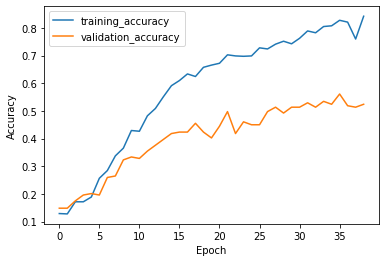

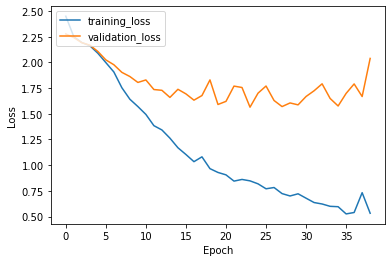


 ### Performance of Test Data ###
Validation Accuracy:  0.523809552192688
Validation Loss:  2.0385279655456543 



In [24]:
plotTrainingAccuracy(history_3)
plotTrainingLoss(history_3)
evaluateModel(model_3, X_val, y_val)

In [25]:
predictions = predictModel(model_3, X_test)
predictions

array([5, 9, 4, 1, 5, 5, 9, 3, 0, 0, 1, 3, 4, 8, 0, 3, 5, 0, 5, 3, 3, 8,
       8, 8, 3, 5, 5, 0, 0, 1, 3, 4, 8, 3, 6, 3, 8, 0, 9, 9, 0, 1, 5, 9,
       8, 0, 3, 3, 3, 7, 3, 6, 0, 0, 8, 3, 5, 3, 0, 0, 8, 6, 8, 6, 0, 0,
       3, 6, 9, 3, 6, 8, 0, 5, 0, 5, 9, 3, 7, 5, 0, 4, 6, 8, 5, 6, 3, 3,
       9, 6, 0, 8, 0, 8, 0, 7, 3, 8, 3, 6, 8, 4, 7, 3, 5, 3, 1, 5, 1, 8,
       0, 0, 7, 5, 0, 0, 0, 5, 5, 4, 5, 0, 3, 1, 0, 0, 3, 8, 0, 3, 8, 7,
       8, 8, 3, 3, 1, 3, 5, 4, 4, 8, 4, 8, 7, 6, 0, 0, 5, 5, 3, 0, 5, 3,
       3, 5, 3, 0, 1, 0, 6, 8, 0, 3, 8, 3, 6, 6, 1, 0, 8, 0, 8, 7, 6, 8,
       3, 0, 6, 5, 5, 5, 8, 3, 8, 1, 0, 7, 0, 3, 3, 6, 8, 4, 3, 8, 4, 5,
       6, 6, 4, 5, 7, 8, 6, 6, 9, 9, 6, 3, 0, 0, 5, 9, 7, 3, 3, 5, 3, 0,
       9, 0, 8, 3, 6, 4, 8, 4, 3, 3, 3, 0, 3, 5, 3, 8, 6, 8, 3, 9, 6, 5,
       6, 3, 8, 5, 3, 6, 9, 8, 3, 0, 6, 8, 0, 5, 8, 3, 3, 6, 3, 3, 7, 8,
       3, 3, 8, 3, 8, 4, 8, 9, 3, 3, 7, 8, 0, 8, 9, 3, 1, 5, 7, 6, 8, 3,
       8, 8, 7, 3, 3, 0, 3, 8, 0, 8, 8, 3, 8, 8, 8,

In [26]:
pd.DataFrame(predictions).to_csv("submission_3.csv")